In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from gpflow.likelihoods import Gaussian
import tikzplotlib
import gpflow
from markovflow.kernels import OrnsteinUhlenbeck
from docs.sde.sde_exp_utils import get_cvi_gpr, get_cvi_gpr_taylor, bitmappify, predict_cvi_gpr_taylor, predict_cvi_gpr

import matplotlib
matplotlib.rcParams['text.usetex'] = True

2022-08-11 10:01:21.959016: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 10:01:21.959040: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-11 10:01:23.978828: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-11 10:01:23.981056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-11 10:01:24.001333: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-11 10:01:24.001356: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-08-11 10:01:24.001362: I tensorflow/stream_execut

In [2]:
seed_id = 33
generate_tex = False

main_dir = os.path.join(r"../data/gpu_training/", str(seed_id))

output_dir = os.path.join(r"output", str(seed_id))

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
extra_axis_parameters = ["axis x line=bottom", "axis y line=left"]

In [3]:
## Utility

def lst_to_str(lst):
    return str(lst).replace("[", "{").replace("]", "}")

## Plot Data

In [4]:
data_path = os.path.join(main_dir, "data.npz")
data = np.load(data_path)

In [5]:
decay = data["decay"]
latent_process = data["latent_process"]
noise_var = data["noise_stddev"]**2
q = data["q"]
time_grid = data["time_grid"]
x0 = data["x0"]
observation_data = (data["observation_grid"].reshape((-1,)), data["observation_vals"].reshape((-1, 1)))
test_data = (data["test_grid"].reshape((-1, )), data["test_vals"].reshape((-1, 1)))

t0 = time_grid[0]
t1 = time_grid[-1]

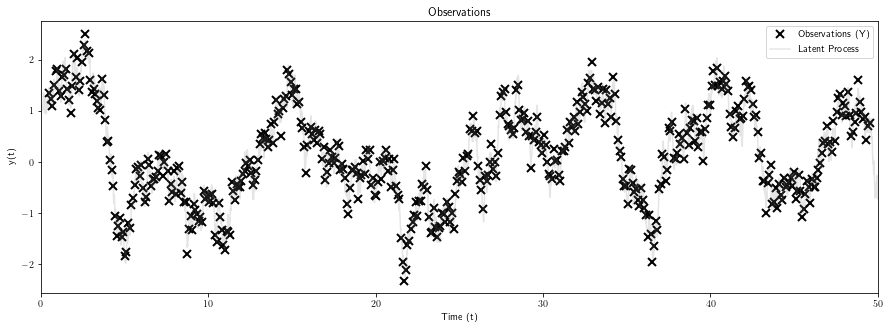

In [6]:
plt.subplots(1, 1, figsize=(15, 5))

plt.plot(observation_data[0].reshape(-1), observation_data[1].reshape(-1), 
         'kx', ms=8, mew=2, label="Observations (Y)")
plt.plot(time_grid, latent_process.reshape(-1), label="Latent Process", alpha=0.2, color="gray")
# plt.plot(test_data[0].reshape(-1), test_data[1].reshape(-1), 'x', color="red", ms=8, mew=2,
#          label="Test Observations (Y)")
plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.title("Observations")
plt.legend()
plt.show()

## Perform GPR

In [7]:
likelihood = Gaussian(noise_var)

kernel = OrnsteinUhlenbeck(decay=2, diffusion=q)  # Change this initial value to match with the initial value of other methods
gpflow.set_trainable(kernel.diffusion, False)

cvi_gpr_model, cvi_params, elbo_vals = get_cvi_gpr_taylor(observation_data, kernel, time_grid, likelihood, 
                                               train=False, sites_lr=0.9)
cvi_gpr_elbo = elbo_vals[-1]

# cvi_gpr_model, cvi_params = get_cvi_gpr(observation_data, kernel, likelihood, train=False, sites_lr=0.9)
# cvi_gpr_elbo = cvi_gpr_model.classic_elbo().numpy().item()

print(f"CVI-GPR ELBO: {cvi_gpr_elbo}")

2022-08-11 10:01:25.624564: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


CVI-GPR ELBO: -209.81978666848352


In [8]:
gpr_m, gpr_S_std = predict_cvi_gpr_taylor(cvi_gpr_model, np.sqrt(noise_var))
# gpr_m, gpr_S_std = predict_cvi_gpr(cvi_gpr_model, time_grid, np.sqrt(noise_var))

# Inference

### Plot ELBO

In [9]:
ssm_1_path = os.path.join(main_dir, "inference_0.01", "ssm_elbo.npz")
ssm_5_path = os.path.join(main_dir, "inference_0.005", "ssm_elbo.npz")
ssm_01_path = os.path.join(main_dir, "inference_0.001", "ssm_elbo.npz")

ssm_1_elbo = np.load(ssm_1_path)["elbo"]
ssm_5_elbo = np.load(ssm_5_path)["elbo"]
ssm_01_elbo = np.load(ssm_01_path)["elbo"]

In [10]:
vgp_1_path = os.path.join(main_dir, "inference_0.01", "vgp_elbo.npz")
vgp_5_path = os.path.join(main_dir, "inference_0.005", "vgp_elbo.npz")
vgp_01_path = os.path.join(main_dir, "inference_0.001", "vgp_elbo.npz")

vgp_1_elbo = np.load(vgp_1_path)["elbo"]
vgp_5_elbo = np.load(vgp_5_path)["elbo"]
vgp_01_elbo = np.load(vgp_01_path)["elbo"]

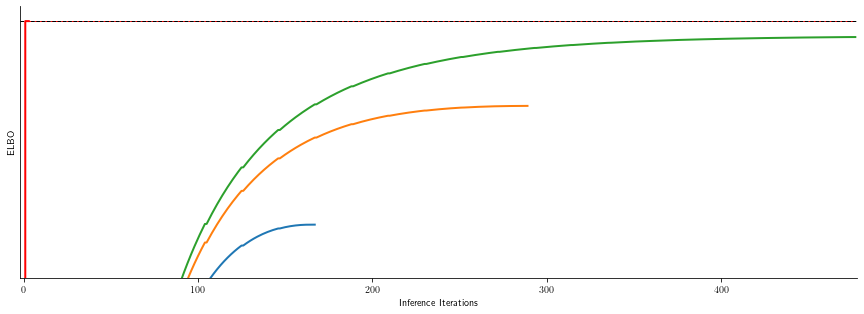

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(ssm_1_elbo, label="t-VGP(dt=0.01)", linewidth=2., color="red")
# plt.plot(ssm_5_elbo, label="Proposed method (dt=0.005)")
# plt.plot(ssm_01_elbo, label="Proposed method (dt=0.001)")

plt.plot(vgp_1_elbo, label="VGP (dt=0.01)", linewidth=2.)
plt.plot(vgp_5_elbo, label="VGP (dt=0.005)", linewidth=2.)
plt.plot(vgp_01_elbo, label="VGP (dt=0.001)", linewidth=2.)

plt.hlines(ssm_1_elbo[-1], len(ssm_1_elbo)-1, len(vgp_01_elbo)-1, color="red", linestyle="dashed", linewidth=1.)

plt.hlines(cvi_gpr_elbo, -2, len(vgp_01_elbo)+2, color="black", linestyle="dashed", linewidth=1., label="GPR (Taylor)")

plt.xlabel("Inference Iterations")
plt.ylabel("ELBO")
# plt.legend()

axis_parameters = extra_axis_parameters.copy()
if seed_id == 33:
    plt.xlim([-2, len(vgp_01_elbo) + 1])
    x_ticks = [0, 100, 200, 300, 400, 500]
    y_ticks = [0, -10000, -20000]
    axis_parameters.append("xtick=" + lst_to_str(x_ticks))
    axis_parameters.append("ytick=" + lst_to_str(y_ticks))
    
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    
    plt.xlim([-2., len(vgp_01_elbo)])
    plt.ylim([-380, -200])
    
elif seed == 66:
    x_ticks = [0, 2, 4, 6, 8]
    y_ticks = [-180, -120, -60]
    axis_parameters.append("xtick=" + lst_to_str(x_ticks))
    axis_parameters.append("ytick=" + lst_to_str(y_ticks))
    
    plt.xlim([-.2, 8.2])
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

ax.tick_params(axis = 'both', which = 'major')
ax.tick_params(axis = 'both', which = 'minor')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

if generate_tex:
    tikzplotlib.save(os.path.join(output_dir, 'elbo_iterations.tex'), figure=fig, axis_width="\\figurewidth",
                     axis_height="\\figureheight", 
                     extra_axis_parameters=axis_parameters)

plt.show()

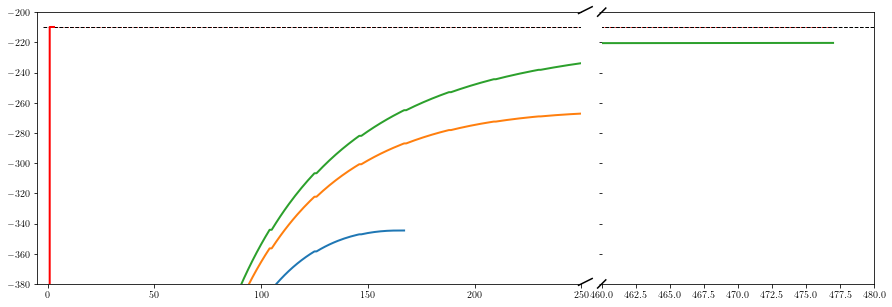

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

fig.subplots_adjust(wspace=0.05, hspace=0)

for a in axs:
    a.plot(ssm_1_elbo, label="t-VGP(dt=0.01)", linewidth=2., color="red")
    a.plot(vgp_1_elbo, label="VGP (dt=0.01)", linewidth=2.)
    a.plot(vgp_5_elbo, label="VGP (dt=0.005)", linewidth=2.)
    a.plot(vgp_01_elbo, label="VGP (dt=0.001)", linewidth=2.)

    a.hlines(ssm_1_elbo[-1], len(ssm_1_elbo)-1, len(vgp_01_elbo)-1, color="red", linestyle="dashed", linewidth=1.)

    a.hlines(cvi_gpr_elbo, -2, len(vgp_01_elbo)+2, color="black", linestyle="dashed", linewidth=1., label="GPR (Taylor)")

# plt.xlabel("Inference Iterations")
# plt.ylabel("ELBO")

plt.ylim([-380, -200])
axs[0].set_xlim(-5, 250)
axs[1].set_xlim(460, 480)

# # hide the spines between ax and ax2
axs[0].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
# axs[0].yaxis.tick_left()
# axs[0].tick_params(labelright='off')
# axs[1].yaxis.tick_right()

# axs[0].set_yticks([-250, -300, -350])
# # axs[1].set_yticks([])

# axs[0].set_xticks([0, 100, 200 , 300])
# axs[1].set_xticks([460, 480])

d1 = .02 # how big to make the diagonal lines in axes coordinates
d2 = .005
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
axs[0].plot((1-d2,1+d1), (-d2,+d1), **kwargs)
axs[0].plot((1-d2,1+d1),(1-d2,1+d1), **kwargs)

d = .015
kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d,+d), (1-d,1+d), **kwargs)
axs[1].plot((-d,+d), (-d,+d), **kwargs)

# plt.setp(axs[0].get_xticklabels(), visible=True)

plt.show()

<Figure size 432x288 with 0 Axes>

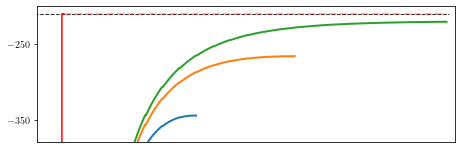

In [13]:
plt.clf()
fig, _ = plt.subplots(1, 1, figsize=(7.5, 2.5))

plt.plot(ssm_1_elbo, label="t-VGP (dt=0.01)", color="red", zorder=3.)

plt.plot(vgp_1_elbo, label="VGP (dt=0.01)", linewidth=2.)
plt.plot(vgp_5_elbo, label="VGP (dt=0.005)", linewidth=2.)
plt.plot(vgp_01_elbo, label="VGP (dt=0.001)", linewidth=2.)

plt.hlines(ssm_1_elbo[-1], len(ssm_1_elbo)-1, len(vgp_01_elbo)-1, color="red", linestyle="dashed", linewidth=2., 
           alpha=0.3)
plt.hlines(cvi_gpr_elbo, -40, len(vgp_01_elbo)+2, color="black", linestyle="dashed", linewidth=1, label="GPR",
           alpha=0.8, zorder=0)

axis_parameters = extra_axis_parameters.copy()

if seed_id == 66:
    yticks = [-56.5, -55.5]
    axis_parameters.append("ytick=" + lst_to_str(yticks))
    
    plt.ylim([-57, -55])
    plt.xlim([0, len(vgp_01_elbo) + .2])
elif seed_id == 33:    
    yticks = [-250, -350]
    axis_parameters.append("ytick=" + lst_to_str(yticks))
    
    plt.yticks(yticks)
    plt.ylim([-380, -200])
    plt.xlim([-30., len(vgp_01_elbo) + 10])

plt.xticks([])

if generate_tex:
     tikzplotlib.save(os.path.join(output_dir, 'elbo_iterations_zoom.tex'), figure=fig, axis_width="\\figurewidth",
                      axis_height="\\figureheight", extra_axis_parameters=axis_parameters)
plt.show()

### Plot Posterior

In [14]:
ssm_inf_1_path = os.path.join(main_dir, "inference_0.01", "ssm_inference.npz")

ssm_inf_1_m = np.load(ssm_inf_1_path)["m"]
ssm_inf_1_S = np.load(ssm_inf_1_path)["S"]
ssm_inf_1_S_std = np.sqrt(ssm_inf_1_S)

In [15]:
vgp_inf_1_path = os.path.join(main_dir, "inference_0.01", "vgp_inference.npz")

vgp_inf_1_m = np.load(vgp_inf_1_path)["m"]
vgp_inf_1_S = np.load(vgp_inf_1_path)["S"]
vgp_inf_1_S_std = np.sqrt(vgp_inf_1_S)

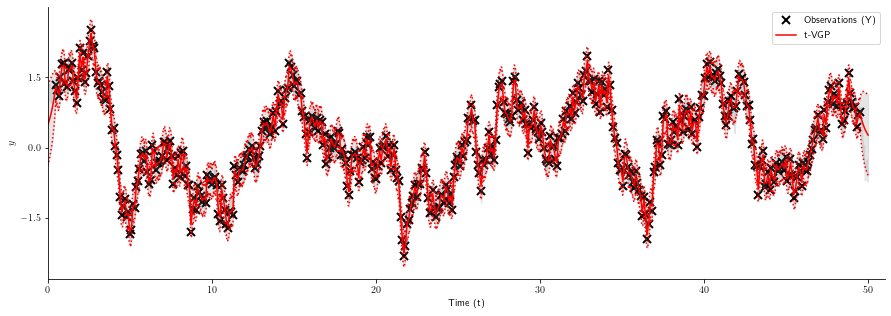

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))


plt.plot(observation_data[0].reshape(-1), observation_data[1].reshape(-1), 
         'kx', ms=8, mew=2, label="Observations (Y)")
plt.plot(time_grid, latent_process.reshape(-1), alpha=0.2, color="gray")
plt.fill_between(
    time_grid,
    y1=(ssm_inf_1_m.reshape(-1) - 2 * ssm_inf_1_S_std.reshape(-1)).reshape(-1, ),
    y2=(ssm_inf_1_m.reshape(-1) + 2 * ssm_inf_1_S_std.reshape(-1)).reshape(-1, ),
    alpha=.2,
    color="gray"
)

# plt.fill_between(
#     time_grid,
#     y1=(vgp_inf_1_m.reshape(-1) - 2 * vgp_inf_1_S_std.reshape(-1)).reshape(-1, ),
#     y2=(vgp_inf_1_m.reshape(-1) + 2 * vgp_inf_1_S_std.reshape(-1)).reshape(-1, ),
#     alpha=.2,
#     color="green"
# )

if generate_tex:
    bitmappify(ax, dpi=300)


plt.plot(time_grid.reshape(-1), ssm_inf_1_m.reshape(-1), label="t-VGP", color="red")
plt.plot(time_grid.reshape(-1), (ssm_inf_1_m.reshape(-1) - 2 * ssm_inf_1_S_std.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="red")
plt.plot(time_grid.reshape(-1), (ssm_inf_1_m.reshape(-1) + 2 * ssm_inf_1_S_std.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="red")

# plt.plot(time_grid.reshape(-1), vgp_inf_1_m.reshape(-1), linestyle="dashed", 
#          color="green", label="Old method")
# plt.plot(time_grid.reshape(-1), (vgp_inf_1_m.reshape(-1) - 2 * vgp_inf_1_S_std.reshape(-1)).reshape(-1, ), 
#          linestyle=(0, (5, 10)), color="green")
# plt.plot(time_grid.reshape(-1), (vgp_inf_1_m.reshape(-1) + 2 * vgp_inf_1_S_std.reshape(-1)).reshape(-1, ), 
#          linestyle=(0, (5, 10)), color="green")

# plt.plot(time_grid.reshape(-1), gpr_m.reshape(-1), linestyle="-.", color="black", alpha=0.8, 
#          label="GPR")
# plt.plot(time_grid.reshape(-1), (gpr_m.reshape(-1) - 2 * gpr_S_std.reshape(-1)).reshape(-1, ), 
#          alpha=0.8, linestyle=(0, (3, 10, 1, 10)), color="black")
# plt.plot(time_grid.reshape(-1), (gpr_m.reshape(-1) + 2 * gpr_S_std.reshape(-1)).reshape(-1, ), 
#          alpha=0.8, linestyle=(0, (3, 10, 1, 10)), color="black")
 
plt.xlim([t0, t1 + 1])
plt.legend()

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

axis_parameters = extra_axis_parameters.copy()
if seed_id == 66:
    x_ticks = [0, 5, 10, 15, 20]
    y_ticks = [-1.5, -0.5, 0.5, 1.5]
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    axis_parameters.append("xtick=" + lst_to_str(x_ticks))
    axis_parameters.append("ytick=" + lst_to_str(y_ticks))
elif seed_id == 33:
    x_ticks = [0, 10, 20, 30, 40, 50]
    y_ticks = [-1.5, 0, 1.5]
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    axis_parameters.append("xtick=" + lst_to_str(x_ticks))
    axis_parameters.append("ytick=" + lst_to_str(y_ticks))

ax.set_xlabel("Time (t)")
ax.set_ylabel("$y$")

if generate_tex:
    tikzplotlib.save(os.path.join(output_dir, 'posterior.tex'), figure=fig, axis_width="\\figurewidth",
                     axis_height="\\figureheight", tex_relative_path_to_data="",
                     extra_axis_parameters=axis_parameters)
plt.show()

## ELBO Bound

In [17]:
bound_path = os.path.join(main_dir, "inference_0.001", "elbo_bound.npz")

In [18]:
bound_data = np.load(bound_path)
decay_vals = bound_data["decay_values"]
gpr_vals = bound_data["gpr_taylor_elbo"]
ssm_vals = bound_data["ssm_elbo"]
vgp_vals = bound_data["vgp_elbo"]

In [19]:
# Load VGP vals for other time-grids
bound_path_1 = os.path.join(main_dir, "inference_0.01", "elbo_bound.npz")
bound_path_5 = os.path.join(main_dir, "inference_0.005", "elbo_bound.npz")

bound_data_1 = np.load(bound_path_1)
bound_data_5 = np.load(bound_path_5)

vgp_vals_1 = bound_data_1["vgp_elbo"]
vgp_vals_5 = bound_data_5["vgp_elbo"]

<Figure size 432x288 with 0 Axes>

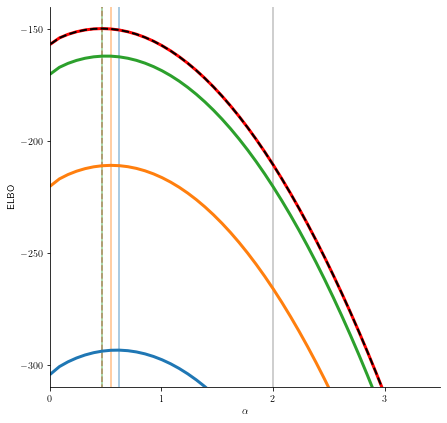

In [20]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plt.plot(decay_vals, ssm_vals, label="t-VGP", color="red", linewidth=3.)
plt.vlines(decay_vals[np.argmax(ssm_vals)], -450, -120, color="red", linestyle="dashed", alpha=0.5)

plt.plot(decay_vals, vgp_vals_1, label="VGP (dt=0.01)", linewidth=3., color="tab:blue")
plt.vlines(decay_vals[np.argmax(vgp_vals_1)], -450, -120, color="tab:blue", alpha=0.5)

plt.plot(decay_vals, vgp_vals_5, label="VGP (dt=0.005)", linewidth=3., color="tab:orange")
plt.vlines(decay_vals[np.argmax(vgp_vals_5)], -450, -120, color="tab:orange", alpha=0.5)

plt.plot(decay_vals, vgp_vals, label="VGP (dt=0.001)", color="tab:green", linewidth=3.)
plt.vlines(decay_vals[np.argmax(vgp_vals)], -450, -120, color="tab:green", alpha=0.5)

plt.plot(decay_vals, gpr_vals, label="Log-likelihood", linestyle="dashed", color="black", linewidth=2.)

# Starting value
plt.vlines(2., -450, -120, color="gray", alpha=0.5)

plt.ylabel("ELBO")
plt.xlabel("$\\alpha$")

plt.xticks([0.0, 1.0, 2.0, 3.0])
plt.xlim([0, 3.5])

axis_parameters = extra_axis_parameters.copy()
if seed_id==33:
    y_tick = [-150, -200, -250, -300]
    plt.yticks(y_tick)
    plt.ylim([-310, -140])
    axis_parameters.append("ytick=" + lst_to_str(y_tick))
#     plt.xlim([0, 1])
#     plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
    
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plt.legend()

if generate_tex:
    tikzplotlibtlib.save(os.path.join(output_dir, 'elbo_bound.tex'), figure=fig, axis_width="\\figurewidth",
                 axis_height="\\figureheight", extra_axis_parameters=axis_parameters)

plt.show()


In [25]:
decay_vals[np.argmax(ssm_vals)], decay_vals[np.argmax(vgp_vals)]

(0.4700000000000001, 0.4700000000000001)

<Figure size 432x288 with 0 Axes>

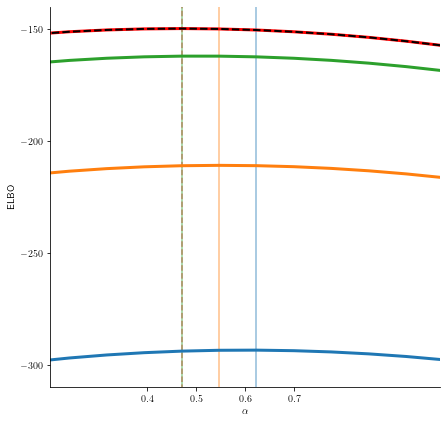

In [21]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plt.plot(decay_vals, ssm_vals, label="t-VGP", color="red", linewidth=3.)
plt.vlines(decay_vals[np.argmax(ssm_vals)], -450, -120, color="red", linestyle="dashed", alpha=0.5)

plt.plot(decay_vals, vgp_vals_1, label="VGP (dt=0.01)", linewidth=3., color="tab:blue")
plt.vlines(decay_vals[np.argmax(vgp_vals_1)], -450, -120, color="tab:blue", alpha=0.5)

plt.plot(decay_vals, vgp_vals_5, label="VGP (dt=0.005)", linewidth=3., color="tab:orange")
plt.vlines(decay_vals[np.argmax(vgp_vals_5)], -450, -120, color="tab:orange", alpha=0.5)

plt.plot(decay_vals, vgp_vals, label="VGP (dt=0.001)", color="tab:green", linewidth=3.)
plt.vlines(decay_vals[np.argmax(vgp_vals)], -450, -120, color="tab:green", alpha=0.5)

plt.plot(decay_vals, gpr_vals, label="Log-likelihood", linestyle="dashed", color="black", linewidth=2.)

# Starting value
plt.vlines(2., -450, -120, color="gray", alpha=0.5)

plt.ylabel("ELBO")
plt.xlabel("$\\alpha$")

axis_parameters = extra_axis_parameters.copy()
if seed_id==33:
    y_tick = [-150, -200, -250, -300]
    plt.yticks(y_tick)
    plt.ylim([-310, -140])
    axis_parameters.append("ytick=" + lst_to_str(y_tick))
    plt.xticks([0.4, 0.5, 0.6, 0.7])
    plt.xlim([0.2, 1.0])
    
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plt.legend()

if generate_tex:
    tikzplotlib.save(os.path.join(output_dir, 'elbo_bound_zoom.tex'), figure=fig, axis_width="\\figurewidth",
                 axis_height="\\figureheight", extra_axis_parameters=axis_parameters)

plt.show()


## Plot ELBO Bounds separately

In [22]:
bound_path_1 = os.path.join(main_dir, "inference_0.01", "elbo_bound.npz")
bound_path_5 = os.path.join(main_dir, "inference_0.005", "elbo_bound.npz")
bound_path_01 = os.path.join(main_dir, "inference_0.001", "elbo_bound.npz")

bound_data_1 = np.load(bound_path_1)
bound_data_5 = np.load(bound_path_5)
bound_data_01 = np.load(bound_path_01)

decay_vals = bound_data_1["decay_values"]
vgp_vals_1 = bound_data_1["vgp_elbo"]
vgp_vals_5 = bound_data_5["vgp_elbo"]
vgp_vals_01 = bound_data_01["vgp_elbo"]
ssm_vals_01 = bound_data_01["ssm_elbo"]

Text(0.5, 1.0, 'VGP (dt=0.001)')

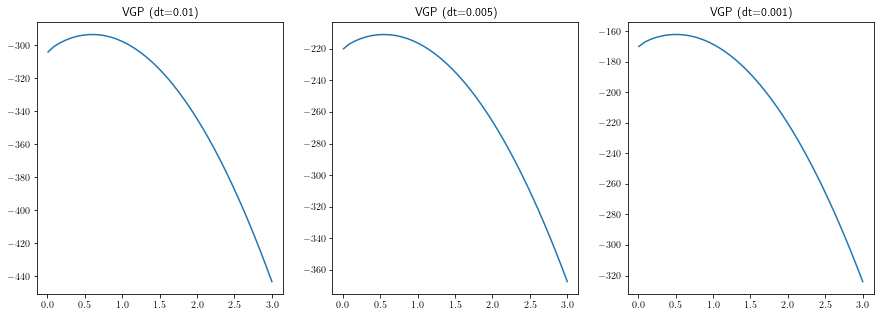

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(decay_vals, vgp_vals_1)
axs[0].set_title("VGP (dt=0.01)")

axs[1].plot(decay_vals, vgp_vals_5)
axs[1].set_title("VGP (dt=0.005)")

axs[2].plot(decay_vals, vgp_vals_01)
axs[2].set_title("VGP (dt=0.001)")

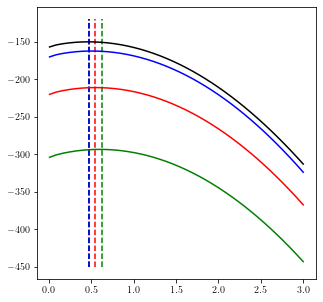

In [24]:
plt.subplots(1, 1, figsize=(5, 5))

plt.plot(decay_vals, ssm_vals_01, color="black")
plt.plot(decay_vals, vgp_vals_1, color="green")
plt.plot(decay_vals, vgp_vals_5, color="red")
plt.plot(decay_vals, vgp_vals_01, color="blue")

plt.vlines(decay_vals[np.argmax(ssm_vals_01)], -450, -120, linestyle="dashed", color="black")
plt.vlines(decay_vals[np.argmax(vgp_vals_1)], -450, -120, linestyle="dashed", color="green")
plt.vlines(decay_vals[np.argmax(vgp_vals_5)], -450, -120, linestyle="dashed", color="red")
plt.vlines(decay_vals[np.argmax(vgp_vals_01)], -450, -120, linestyle="dashed", color="blue")

# plt.xlim([0, 1])

plt.show()